[Unsupervised Learning] Predictive Analysis (Kmeans Clustering)
---
Diogo Pessoa

Using the added features, I'll apply K-means clustering to find the most popular source stations by time of day.
##### Clustering:

Run an initial KMeans clustering with a default of k=5 clusters, then apply the silhouette index to look for the optimal number of clusters.
Compare and plot results.
In a real-world scenario, the period of the day (Morning, Afternoon, Evening, and Night) is not granular enough. To get better accuracy in the prediction, to confidently allocate, employees to relocate bikes. We should consider shorter time windows, increasing  granularity, such as 15-minute intervals.

#### [Supervised Learning] Predictive Analysis (Regression)

Explore a predictive analysis using regression models to improve user experience. Refining the re-stock strategy by considering the bike type per route, to predict the number of bikes needed at each station at different times of the day.

* Apply regression models to predict the number of bikes needed at each station at different times of the day.
* Bike type per routes, to predict the number of bikes needed at each station at different times of the day.


In [1]:
# Uncomment this Section if running locally or working on this notebook and loading dataset directly here.
# import os
# import sys
#
# from dotenv import load_dotenv
#
# # Load environment variables from a .env file
# load_dotenv()
# images_path = os.getenv('IMAGES_PATH')
# data_dir = os.getenv('DATA_COLLECTION_DIR')
#
# # Loading local helper modules
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# # data_collection
# %run './data_collection.ipynb'
# # features engineering
# %run './feature_engineering.ipynb'
# """
# Local Dataset from local files (download if not present)
#  :returns sampled_df_with_added_features: DataFrame, sampled_df_with_added_features_indexed: DataFrame
# """

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/07 09:05:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/07 09:05:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/02/07 09:05:42 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/02/07 09:05:42 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


loading data to spark: divvy_df ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']


+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+---------+---------+---------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat|start_lng|  end_lat|  end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+---------+---------+---------+-------------+
|000057DEB12BFF9E|electric_bike|2023-06-22 18:09:33|2023-06-22 18:16:57|Franklin St & Ill...|             RN-|Ogden Ave & Race Ave|         13194|41.891018|-87.63539|41.891796|-87.65875|       member|
|00010F17355ACF5A|electric_bike|2023-07-28 17:52:48|2023-07-28 17:58:25|Milwaukee Ave & G...|           13033|Noble St & Milwau...|         13290|41.891514|-87.64844| 41.90068| -87.6626|       cas

loaded sampled_df_with_added_features with 43346 
 and columns ['end_station_id', 'start_station_id', 'ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual', 'start_station_name', 'end_station_name', 'day_period', 'week_day']


loaded sampled_df_with_added_features_indexed with 43346 
 and columns ['end_station_id', 'start_station_id', 'ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual', 'start_station_name', 'end_station_name', 'day_period', 'week_day', 'start_station_id_index', 'end_station_id_index', 'member_casual_index', 'day_period_index', 'week_day_index', 'rideable_type_index']


'\nLocal Dataset from local files (download if not present)\n :returns sampled_df_with_added_features: DataFrame, sampled_df_with_added_features_indexed: DataFrame\n'

In [15]:
features = ['start_station_id_index', 'end_station_id_index', 'day_period_index', 'week_day_index', 'rideable_type_index']

In [16]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features, outputCol="features")
# # Scaling the features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# # Combine the VectorAssembler and StandardScaler into a Pipeline
from pyspark.ml import Pipeline

# You can now define a pipeline that includes both the assembler and the scaler
pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform the DataFrame using the defined pipeline
sampled_df_scaled = pipeline.fit(sampled_df_with_added_features_indexed).transform(
    sampled_df_with_added_features_indexed)

In [17]:

from pyspark.ml.clustering import KMeans

# Initialize KMeans with the specified number of clusters (k) and a seed for reproducibility
k = 3
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")

# Fit the model to the data
model = kmeans.fit(sampled_df_scaled)

# Transform the dataset to include cluster predictions
predictions = model.transform(sampled_df_scaled)

# Silhouette Score with k=5: 0.5733339010164845

In [7]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

# Initialize PCA model to reduce to 2 components
pca = PCA(k=2, inputCol="scaled_features", outputCol="features_pca")
pcaModel = pca.fit(predictions)

# Apply PCA to the data
result = pcaModel.transform(predictions)

# Extract PCA features for plotting
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))
result = result.withColumn("features_pca", to_array("features_pca"))

# Now, result contains a 'prediction' column from KMeans and 'features_pca' column for plotting


24/02/07 09:23:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [8]:
result_pd = result.select("prediction", "features_pca").toPandas()

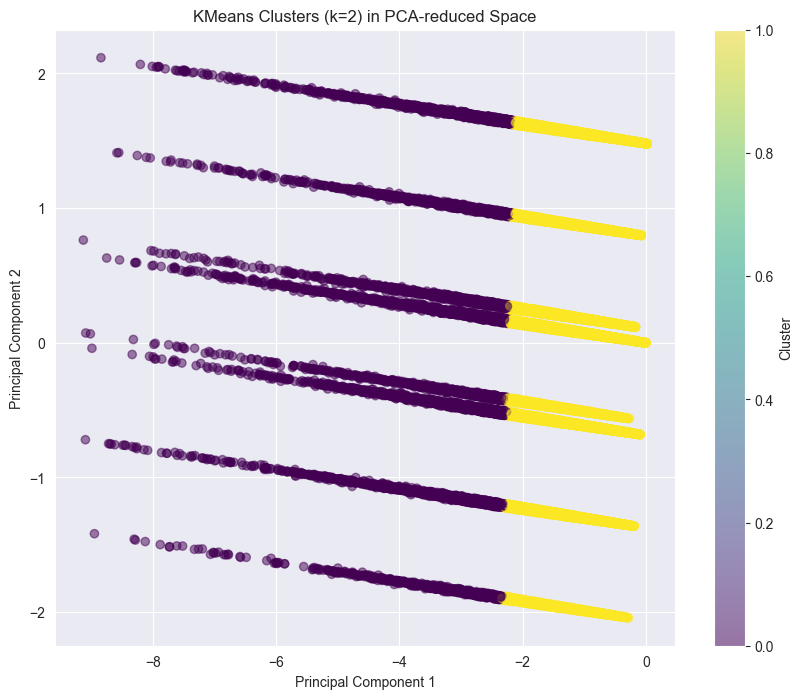

In [9]:
import matplotlib.pyplot as plt

# Separate the PCA features into X and Y coordinates for plotting
X = [x[0] for x in result_pd["features_pca"]]
Y = [y[1] for y in result_pd["features_pca"]]

# Create a scatter plot, colored by cluster prediction
plt.figure(figsize=(10, 8))
plt.scatter(X, Y, c=result_pd["prediction"], cmap='viridis', alpha=0.5)

plt.title(f'KMeans Clusters (k={k}) in PCA-reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig(os.path.join(images_path, 'k_means_clusters_PCA_reduced.png'))
plt.colorbar(label='Cluster')
plt.show()

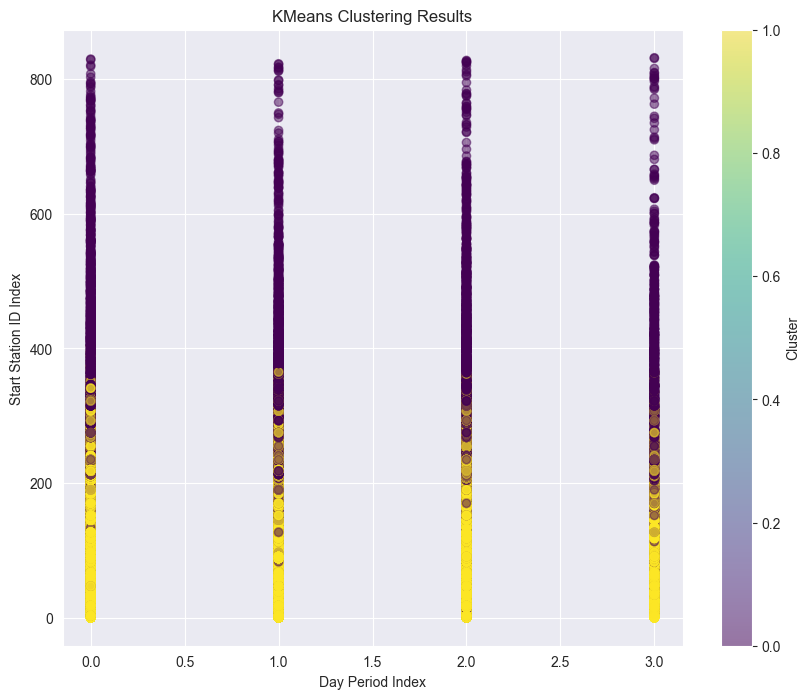

In [10]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas for plotting (assuming this is manageable size-wise)
pandas_df = predictions.select('day_period_index', 'start_station_id_index', 'prediction').toPandas()

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pandas_df['day_period_index'], pandas_df['start_station_id_index'], c=pandas_df['prediction'],
                      cmap='viridis', alpha=0.5)

# Assuming 'day_period_index' and 'start_station_id_index' are numeric or have been appropriately converted for plotting
plt.title('KMeans Clustering Results')
plt.xlabel('Day Period Index')
plt.ylabel('Start Station ID Index')
plt.colorbar(scatter, label='Cluster')
plt.savefig(os.path.join(images_path, 'k_means_clusters_day_period_start_stations.png'))
plt.show()


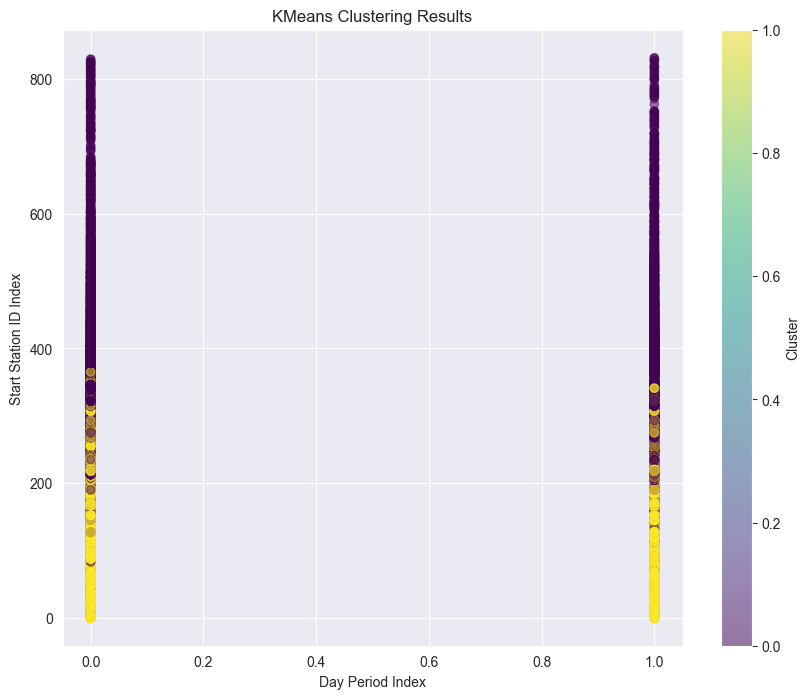

In [11]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas for plotting (assuming this is manageable size-wise)
pandas_df = predictions.select('week_day_index', 'start_station_id_index', 'prediction').toPandas()

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pandas_df['start_station_id_index'], pandas_df['week_day_index'], c=pandas_df['prediction'],
                      cmap='viridis', alpha=0.5)

# Assuming 'day_period_index' and 'start_station_id_index' are numeric or have been appropriately converted for plotting
plt.title('KMeans Clustering Results')
plt.xlabel('Day Period Index')
plt.ylabel('Start Station ID Index')
plt.colorbar(scatter, label='Cluster')
plt.savefig(os.path.join(images_path, 'k_means_clusters_workday_start_stations.png'))
plt.show()


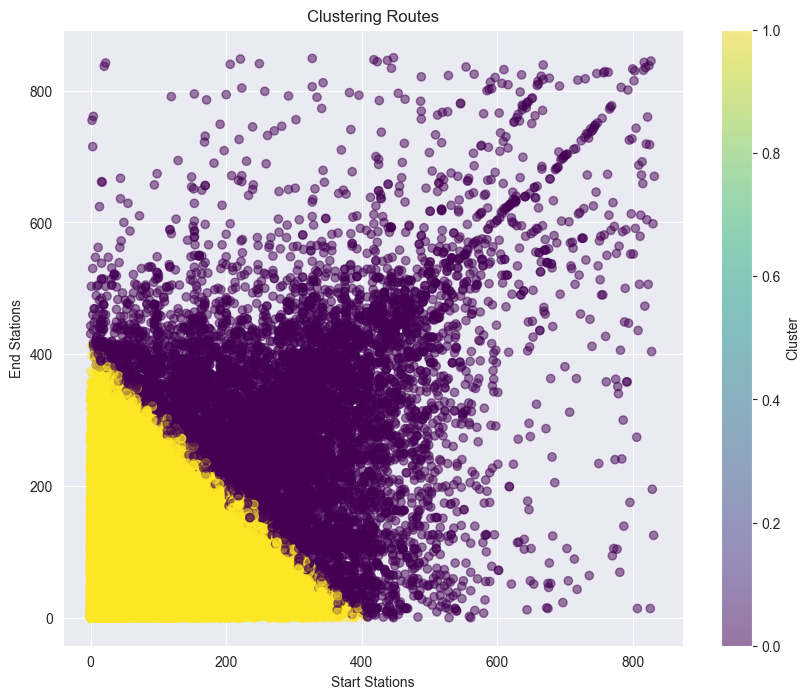

In [14]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas for plotting (assuming this is manageable size-wise)
pandas_df = predictions.select('end_station_id_index', 'start_station_id_index', 'prediction').toPandas()

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pandas_df['start_station_id_index'], pandas_df['end_station_id_index'], c=pandas_df['prediction'],
                      cmap='viridis', alpha=0.5)

# Assuming 'day_period_index' and 'start_station_id_index' are numeric or have been appropriately converted for plotting
plt.title('Clustering Routes')
plt.xlabel('Start Stations')
plt.ylabel('End Stations')
plt.colorbar(scatter, label='Cluster')
plt.savefig(os.path.join(images_path, 'k_means_clusters_end_start_stations.png'))
plt.show()